In [3]:
import numpy as np
import os
import time
from keras.applications import VGG16
from keras.preprocessing import image
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from PIL import Image


# Loading the training data
PATH = os.getcwd()

# input image dimensions
img_rows, img_cols = 224, 224
#data path
dirname='../dataTL/'
#Our pipeline########################################################################################
dim=(img_rows, img_cols)

X_data = [] # for keeping the image
y_data = [] # for keeping the image label id
label_name = [] # for keeping the label dictionary
label_cpt = 0 # Label id star at index 0

for class_directory in os.listdir(dirname): 
    if os.path.isdir(os.path.join(dirname, class_directory)): 
        for filename in os.listdir(os.path.join(dirname,class_directory)): 
            
            img_path = os.path.join(dirname, class_directory, filename)
            if img_path.endswith(".jpg"): 
                #print("Loading Image")
                #img=cv2.imread(img_path)
                img = Image.open(img_path).resize((dim))
                images = np.array(img).astype(np.float32)
                #images = img.astype('float32')
                images /= 255
                
                X_data.append(images)
                y_data.append(label_cpt)
        label_name.append(class_directory)
        label_cpt += 1 # Label id incrementation
# if label_cpt >= 10: break; # Uncomment to limit to 10 classes
y_data = np.array(y_data)
X_data = np.array(X_data)
label_name = np.array(label_name)

nb_classes = np.max(y_data)+1 # count how many classes in the dataset
print("Nb classes:", nb_classes)

y_data = np_utils.to_categorical(y_data, nb_classes)

#Y = np_utils.to_categorical(labels, num_classes)

#arr = np.arange(len(X_data)) 
#np.random.shuffle(arr) 

x,y = shuffle(X_data,y_data, random_state=2)

#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

print(X_train.shape)


/home/ec2-user/anaconda3-501/envs/keras200/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Nb classes: 4
(640, 224, 224, 3)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Train on 640 samples, validate on 160 samples
Epoch 1/12
640/640 [==============================] - 17s - loss: 1.2459 - acc: 0.4969 - val_loss: 0.7741 - val_acc: 0.6500
Epoch 2/12
640/640 [==============================] - 13s - loss: 0.5177 - acc: 0.7984 - val_loss: 0.5031 - val_acc: 0.7750
Epoch 3/12
640/640 [==============================] - 13s - loss: 0.2677 - acc: 0.9156 - val_loss: 0.2887 - val_acc: 0.9375
Epoch 4/12
640/640 [==============================] - 13s - loss: 0.1474 - acc: 0.9609 - val_loss: 0.3503 - val_acc: 0.8250
Epoch 5/12
640/640 [==============================] - 13s - loss: 0.0855 - acc: 0.9859 - val_loss: 0.2398 - val_acc: 0.8938
Epoch 6/12
640/640 [==============================] - 13s - loss: 0.0467 - acc: 0.9937 - val_loss: 0.3223 - val_acc: 0.8938
Epoch 7/12
640/640 [==============================] - 13s - loss: 0.0374 - acc: 0.9984 - val_loss: 0.2010 - val_acc: 0.9313
Epoch 8/12
640/640 [==============================] - 14s - loss: 0.0218 - acc: 1.0000

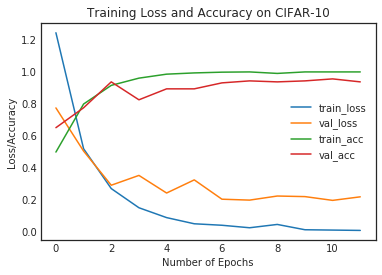

In [4]:
#Training the feature extraction also
num_classes = 4
image_input = Input(shape=(224, 224, 3))

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

model.summary()

last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_dense_model = Model(image_input, out)
custom_dense_model.summary()

# freeze all the layers except the dense layers
for layer in custom_dense_model.layers[:-3]:
    layer.trainable = False

custom_dense_model.summary()

custom_dense_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

t=time.time()

H = custom_dense_model.fit(X_train, y_train, batch_size=32, epochs=12, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_dense_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

nb_epochs=12
# plot the training loss and accuracy
import matplotlib.pyplot as plt
plt.style.use("seaborn-white")
plt.figure()
plt.plot(np.arange(0, nb_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, nb_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, nb_epochs), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, nb_epochs), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()